# Routing Algorithm server load test

In order to allow the eClever Routing algorithm to process multiple parallel request, we have implemented [*Gunicorn*](https://gunicorn.org/) as Web Server Gateway Interface (WSGI). As stated in its documentation, Gunicorn is based on the pre-fork worker model. This means that there is a central master process that manages a set of worker processes. The master never knows anything about individual clients. All requests and responses are handled completely by worker processes. The master process is a simple loop that listens for various process signals and reacts accordingly. It manages the list of running workers and tells the master to increase or decrease the number of running workers depending on the needs. It will also automatically restart failed workers. 

A critical configuration parameter in Gunicorn is the class of workers to be used. 

There are basically three types, *sync*, *async* and *asyncIO*.

+ **Sync Workers:**
A synchronous worker class handles a single request at a time. The maximal number of parallel request (concurrency) that such worker class can handle is limited by the amount of workers, e.g., three workers will handle three request in parallel, additional requests will queue. This kind of workers are best suitable when the requested process is CPU bound.


+ **Async Workers (gevent, eventlet):**
Asynchronous workers available in Gunicorn are based on Greenlets (via Eventlet and Gevent). Greenlets are an implementation of cooperative multi-threading for Python. Here, multiple requests would be handled by one process (worker). That process would not wait for IO to finish as *sync* workers will do, instead it will continue to handle other requests. In theory, it has unlimited concurrency. This kind of workers are best suitable when the requested process is IO bound.


+ **AsyncIO Workers (gthread):**
With this worker class, Gunicorn prepares the worker process on startup. When a request is coming, one of these processes would fork a thread to handle that request. In theory, the maximum concurrency number equals to the number of the worker process times the number of threads. 

Regarding the amount of workers that one could choose to work with, the Gunicorn documentation recommends something around $(x\times \rm{n\_cores})+1$ with $x$ between 2 and 4.

## Strategy

In order to identify which of these worker classes better suits or needs, we have prepare a set of load tests where we have choose one of the classes with different configurations setup. For Async workers (gevent, eventlet) we have varied the amount of workers between 3 and 9. Whereas for AsynIO workers (gthread) we have varied the combination of $workers \times threads$ to be equal to 8. This is because, as already mentioned, the amount of parallel processes for such workers is limited to the amount of $workers \times threads$ and should be equal to a number around $x \times \rm {n\_cores}$ with x between 2 and 4.

The load test used was a ramp up test. Here we send a number of concurrent (parallel) request starting from 10 request during 10 minutes. After this time is over, we increase the amount of concurrent users by 10 and hold again for 10 minutes. We keep doing this until we reach 150 concurrent users.

These tests where ran using the package [siege](https://www.joedog.org/), with the following setup:

`siege --concurrent=N --time=10M -d1 --header "Origin: localhost" -f 'test_urls.txt --internet`

Where N is the number of concurrent users. The file *test_urls.txt* contains a set of about 140 route request generated using a vast combination of origin, destinations and different EV models with varying start SOC values. The *--internet* parameter is used in conjunction with the *test_urls.txt* file, this causes each user to randomly hit one of the URLs, with no predetermined pattern similar to real life conditions.

## Metrics

To analyze the effect of the ramp up test, the following metrics will be considered:
+ **Response time:** Average time (seconds) it took to respond to each simulated user’s requests.  
+ **Transaction rate:** Average number of transactions the server was able to handle per second.
+ **Concurrency:** It is defined as the sum of all transaction times divided by the total elapsed time (10 min). That tells us how many processes were handled simultaneously.
+ **Availability:** Percentage from the total requests that the server was able to process.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gunicorn_siege_test import read_logs, read_session_res

def path_data(wk_class, workers, threads):
    return "/home/jehamann/eClever/repositories/jupyter-docs/routing-algorithm/"\
           "siege/tests/ramp_up_test/{}/{}w_{}th/".format(wk_class, workers, threads)

def get_stats_session(wk_class, workers, threads):
    path = path_data(wk_class, workers, threads)
    all_stats = pd.DataFrame()
    for concurrent in [10*(n+1) for n in range(15)]:
        data_file = path + "test_rampup_{}w_{}th_{}c.txt".format(workers, threads, concurrent)
        data_df = read_session_res(data_file)
        stats = data_df.describe().time
        stats['workers'] = workers
        stats['threads'] = threads
        stats['concurrent'] = concurrent
        all_stats = pd.concat([all_stats, stats], axis=1)
        
    all_stats = all_stats.T.reset_index(drop=True)
    logfile = path + "siege.log"
    res_data = pd.read_csv(logfile)
    res_data['Availability'] = res_data['    OKAY'] * 100 / (res_data['    OKAY'] + res_data['   Failed'])

    return pd.concat([res_data, all_stats], axis=1)

def plot_cols(df, col):
    
    titles_dict = {'  Resp Time': "Response time [s]", 
                   '  Trans Rate': "Transaction rate [trans/sec]", 
                   '  Concurrent': "Concurrency", 
                   '    OKAY': "Successful transactions", 
                   '   Failed': "Failed transactions",
                   'mean': "Response time [s]",
                   'Availability': "Availability [%]"}
    color_dict = {0:'b', 1:'green', 2:'orange', 3:'red'}
    
    for i, worker in enumerate(df.workers.unique()):
        filtered = df[df.workers==worker]
        x = filtered['concurrent']
        y = pd.to_numeric(filtered[col])
        ax.plot(x, y,  'o--', alpha = 0.5, label=worker, c=color_dict[i])
        ax.plot(x, fit_curve(x, y, 1)[0](x), '-', label='fit', lw=2, c=color_dict[i])

    ax.set_xlabel('Concurrent users', fontsize="x-large")
    ax.set_ylabel(titles_dict[col], fontsize="x-large") 
    

def fit_curve(x, y, degs):
    fit_params = np.polyfit(x, y, deg=degs)
    curve = np.poly1d(fit_params)
    return curve, fit_params

# Results

Let us start the analysis of the load test by separating the discussion by worker type

## gevent workers

Below is a graph of the above defined metrics as a function of concurrent virtual users for 3 (blue), 5 (green) and 9 (orange) workers. As observed, the response time increases as the amount of concurrent users increases from a value of ~45 seconds up to 300 seconds. Larger respond times are obtained when using 3 workers, slightly better values are obtained using 9 workers. 

Switching to the transaction rate, we see how this value decreases as the amount of virtual concurrent users increases. Transaction rate rapidly decreases from a value of 0.2 trans/sec (12 transaction/min) down to 0.025 trans/sec (1.5 Trans/min). These values are rather comparable for all set of workers.

Regarding concurrency, this value increases with the number of concurrent users, although, it never equals the amount of users. This means that upon increasing concurrent users, the server is not able to process all request simultaneously.

Finally, the availability rapidly decreases so that for 50 concurrent virtual users, the server is able to process only 50% of the requests. Among all configurations, the performance is comparable.

Now, since the overall behavior of the performance metrics is very similar for all set of worker configurations we need a way to select which configuration performs the best. To do so we have assumed a linear behavior of the metrics as a function of concurrent users and performed a linear regression to the data. The solid lines in the figure below is the result of this linear approximation.  

We also need to define quality standards for the server, in order to choose a configuration. For instance, we would like that the average response time to be the shortest possible, with a high transaction rate, we also want a concurrency that scales with the amount of concurrent users and, off course, it is desired that the server has a high availability. 

Considering this, the configuration with 5 workers is perhaps the best option. Even though the response time is larger than a configuration with 9 workers, the transaction rate is the largest, specially after 50 concurrent users. Also the concurrency has a similar trend as that of 9 workers while having a larger availability. The 1 worker configuration we rule out since it has the largest response time and the transaction rate drops considerably above 50 concurrent users.

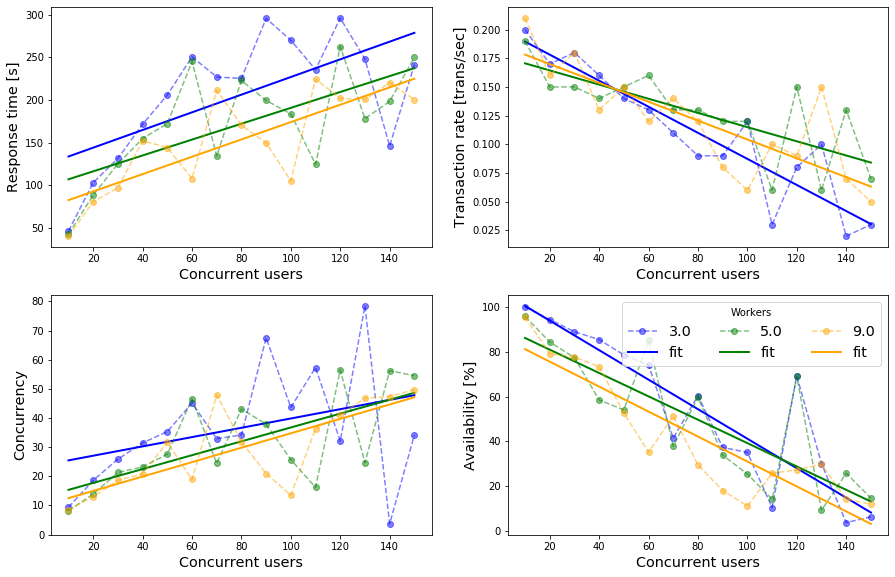

In [2]:
gevent_data = pd.DataFrame()
for worker in [3, 5, 9]:
    gevent_data = pd.concat([gevent_data, get_stats_session("gevent", worker, 1)])
    
cols = ['mean', '  Trans Rate', '  Concurrent', 'Availability']

fig = plt.figure(figsize=(15,15))
for n, col in enumerate(cols):
    ax = fig.add_subplot(3,2, 1+n)
    plot_cols(gevent_data, col)
ax.legend(title='Workers', fontsize="x-large", ncol=3); 

## eventlet workers

Let us now try a similar analysis but this time using the *eventlet* worker class. Below is again a plot of the different performance metrics as a function of concurrent users, together with a linear regression model. Following the same considerations done on the previous discussion we see that the best configuration is in this case the one where workers = 9. This configuration has the shortest response time and the largest transaction rate. The availability is almost equal to that of 5 workers. Perhaps the weakest point is the concurrency which is the lowest.

In [3]:
eventlet_data = pd.DataFrame()
for worker in [3, 5, 9]:
    eventlet_data = pd.concat([eventlet_data, get_stats_session("eventlet", worker, 1)])

fig = plt.figure(figsize=(15,15))
for n, col in enumerate(cols):
    ax = fig.add_subplot(3,2, 1+n)
    plot_cols(eventlet_data, col)
ax.legend(title='Workers', fontsize="x-large"); 

## gthread workers

Turning into the SyncIO type of workers, we have also made some tests using the gthread worker class. In this case, we tried four different configurations namely:

| Conf.| Workers| Threads |
| -----| -------|:-------:|
| **1**| 1      | 8       |
| **2**| 2      | 4       |
| **3**| 4      | 2       |
| **4**| 8      | 1       |    

Below are the performance metrics plots with their correspondent linear regressions. We see that the worst configuration is that with 1 worker and 8 threads (blue), here the response time quickly increases and the transaction rate decreases steeply. Also, above 70 concurrent users the server is not able to process any other request. The configuration with 8 workers and 1 thread (red) also shows a rather bad behavior, although, the transaction rate is the highest and the response time the shortest, the server availability is the worst. Hence for this type of worker class, the best configuration is that with 4 workers and 2 threads. It has relatively short response time and transaction rate comparable to that of 2 workers 4 threads configuration. Also the server availability is always, higher than 90%.  

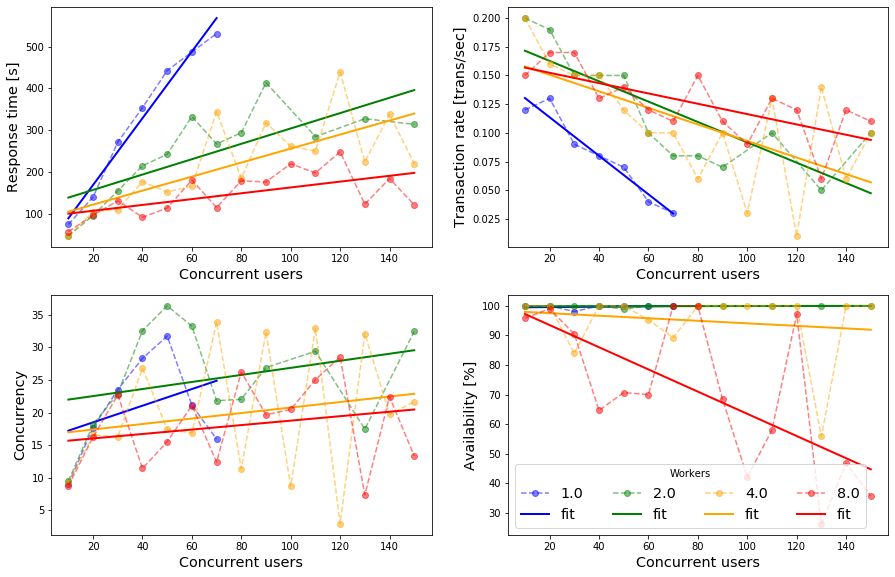

In [4]:
gthread_data = pd.DataFrame()
for worker, thread in [(1, 8), (2, 4), (4, 2), (8, 1)]:
    gthread_data = pd.concat([gthread_data, get_stats_session("gthread", worker, thread)])

fig = plt.figure(figsize=(15,15))
for n, col in enumerate(cols):
    ax = fig.add_subplot(3,2, 1+n)
    plot_cols(gthread_data.dropna(), col)
ax.legend(title='Workers', fontsize="x-large", ncol=4); 

 ## Worker classes comparison
 
To finalize lets try to compare the best configuration for all worker class and finally choose the best one among all.

Below is a figure comparing the performance metrics of the best configuration for the different worker classes previously discussed, i.e, gevent with 5 workers (blue), eventlet with 9 workers (green) and gthread with 4 workers and 2 threads (orange). 

Starting with gthread (orange) we see that this worker class delivers the largest response time, it also has the lowest transaction rate and the lowest concurrency, which means that the handling of multiple concurrent users is lower for this worker class. However, it has the largest server availability. 

If we now compare gevent and eventlet workers, these are very similar in behavior, their availability is almost equal, although gevent has slightly larger values. Transfer rate is also rather similar, however, at lower concurrent users (below 70) gevent workers tend to have smaller transaction rates than eventlet workers, this behavior is inverted above 70 concurrent users. 

The response time is slightly better for the eventlet workers. In contrast, concurrency is much better for gevent workers meaning that gevent workers tend to process more parallel requests as the others.

In [5]:
data_comp = pd.concat([gevent_data[gevent_data.workers==5],
                       eventlet_data[eventlet_data.workers==9],
                       gthread_data[gthread_data.workers==4],
                       ])

fig = plt.figure(figsize=(15,15))
for n, col in enumerate(cols):
    ax = fig.add_subplot(3,2, 1+n)
    plot_cols(data_comp, col)

legend_titles = ['gevent 5w', 'fit', 'eventlet 9w', 'fit', 'gthread 4w 2thr', 'fit']
ax.legend(legend_titles, fontsize="x-large", ncol=3); 

A final comment on the availability for AsyncIO and Async worker classes, although, it seems that availability for gthread is rather high, one needs to consider that, the way these workers process data is that they take one request per worker-thread, other requests are blocked until the first ones are processed. In this way, all process that the server takes (blocked ones are not considered) are processed, hence, the availability values are high. 

Async workers, on the other hand, are able to spawn many more processes in pseudo-threads, about $1000 \times \rm{workers}$. Hence, the server takes many more processes as compared to e.g., gthread. However, it cannot process them all in the time interval of our test (10 min per step), that is why the availability values for such workers decreases that much upon increasing the amount of concurrent users.

We can rapidly check how many request each of these configurations were actually processed during the whole test, if the values are similar then the availability metric is misleading if we want to use it to compare AsyncIO and Async worker classes

The table below, shows the total amount of request successfully processed during the whole test for all worker classes, as can be observed, gevent and eventlet workers have actually processed much more requests as gthread. Therefore, the availability metric is not a good paramater to compare AsyncIO and Async workers.

In [6]:
grouped = data_comp[['  Trans', 'workers', '    OKAY', '   Failed']].groupby('workers').sum()
grouped.index=['gthread 4w 2th', 'gevent 5w', 'eventlet 9w']
grouped

Trans      OKAY     Failed
gthread 4w 2th      964       964         95
gevent 5w          1132      1132       1776
eventlet 9w        1144      1144       2424

Under these circumstances, we can then say that the best configuration for our Route Algorithm server is that using gevent with 5 workers. It has the similar transaction rate as compared to eventlet workers, still having a larger concurrency and availability. Its response time is slightly larger but its concurrency and availability is better.